# Jose Andrés Henao Alzate
# CC 1036686332

# Embedded ML - Lab 1.2: Model Compression

In this lab you are asked to create a compressed verion of an ANNs model. You are not allowed to use ML libraries such as SciKit-learn, PyTorch or TensorFlow, but you are allowed to use standard libraries such as math, numpy and matplotlib if needed. You are given some code but you are expected to write some more and be able to explain and modify everything. This lab is essential for you to grasp the details of some of the most important techniques for compressing or making ML models more efficient: quantization and pruning.

### Learning outcomes


* Explain the basic concepts of compression in ANNs
* Apply range tuning and centering when doing quantization
* Calculate and analyze the impact of quantization and pruning on memory and computing

### Naive quantization
Quantization means reducing the precission of model parameters and mainly targets weights, since they represent the most volumne of memory and processing in ANNs.

Take the code from the last part of Lab 1.1 (MNIST model) and add methods to export and import weights to and from a binary file, making sure both processes work with your code in such a way that you don't have to train every time you want to run inference, but insted, the wieghts are loaded into the model when needed. Investigate which serialization/desarialization options exist in Python and choose one that you understand.

Then, create two additional inference methods: FP16 and INT8. The FP16 method should treat all computations in the network involving the weights, as 16-bit floating-point. The INT8 method should work with 8-bit integers instead. In both cases, use the native datatype conversion methods. Investigate the NumPy methods available to enforce the desired datatypes.

Run the two quantized models and compare them with the baseline in terms of model size, accuracy and latency.

In [63]:
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# --------- Utilidades ---------

def one_hot(etiquetas):
    salida = np.zeros((len(etiquetas), 10))
    for i, valor in enumerate(etiquetas):
        salida[i][valor] = 1
    return salida

# --------- Clase de Red Neuronal ---------

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(42)
        self.w1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def derivada_sigmoid(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def mse(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))
#-----------Se serializan los pesos usando pickle
    def save_weights(self, hidden_size):
        pesos = {
            'w1': self.w1,
            'b1': self.b1,
            'w2': self.w2,
            'b2': self.b2
        }
        with open(f"pesos_{hidden_size}.bin", "wb") as archivo_de_pesos:
            pickle.dump(pesos, archivo_de_pesos)
#----------Método para cargar los pesos desde un archivo.
    def load_weights(nombre_archivo):
        with open(nombre_archivo, 'rb') as archivo:
            pesos = pickle.load(archivo)
        return pesos

#---------- Método para inferecia de Fp16.
    def FP16(self,x):
      w1_fp16 = self.w1.astype(np.float16)
      b1_fp16 = self.b1.astype(np.float16)
      w2_fp16 = self.w2.astype(np.float16)
      b2_fp16 = self.b2.astype(np.float16)

      z1 = np.dot(x.astype(np.float16), w1_fp16) + b1_fp16
      a1 = self.sigmoid(z1)
      z2 = np.dot(a1, w2_fp16) + b2_fp16
      a2 = self.softmax(z2.astype(np.float32))

      return a2

#---------- Método para inferecia de INT8.

    def INT8(self, x):

  # Convertir pesos a INT8 (usando rango completo de 8 bits)
        w1_int8 = self.w1.astype(np.int8)
        b1_int8 = self.b1.astype(np.int8)
        w2_int8 = self.w2.astype(np.int8)
        b2_int8 = self.b2.astype(np.int8)

        # Primera capa: operaciones en INT8
        z1_int8 = (np.dot(x.astype(np.int8), w1_int8) + b1_int8)
        a1_int8 = self.sigmoid(z1_int8)

        # Segunda capa: operaciones en INT8
        z2_int8 = (np.dot(a1_int8, w2_int8) + b2_int8)
        a2_int8 = self.softmax(z2_int8)

        return a2_int8.astype(np.float32)

    def forward(self, x):
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def backward(self, x, y, salida, learning_rate):
        error = salida - y
        d_w2 = np.dot(self.a1.T, error)
        d_b2 = np.sum(error, axis=0, keepdims=True)

        d_a1 = np.dot(error, self.w2.T) * self.derivada_sigmoid(self.a1)
        d_w1 = np.dot(x.T, d_a1)
        d_b1 = np.sum(d_a1, axis=0, keepdims=True)

        self.w2 -= learning_rate * d_w2
        self.b2 -= learning_rate * d_b2
        self.w1 -= learning_rate * d_w1
        self.b1 -= learning_rate * d_b1

    def train(self, X, y, epochs, learning_rate, X_val, y_val, hidden_size):
        errores = []
        precisiones = []
        tiempos = []
        operaciones = []

        for epoca in range(epochs):
            inicio = time.time()

            salida = self.forward(X)
            error = self.mse(y, salida)
            self.backward(X, y, salida, learning_rate)

            predicciones = np.argmax(self.forward(X_val), axis=1)
            reales = np.argmax(y_val, axis=1)
            precision = np.mean(predicciones == reales)

            fin = time.time()
            forward_ops = 2 * (hidden_size * (784 + 1) + 10 * (hidden_size + 1))

            errores.append(error)
            precisiones.append(precision)
            tiempos.append(fin - inicio)
            operaciones.append(forward_ops)

            #print(f"Época {epoca+1}: Error={error:.4f}, Precisión={precision*100:.2f}%, Tiempo={fin - inicio:.2f}s")

        return errores, precisiones, tiempos, operaciones




    def comparar_modelos(self, x_test, y_test):
        resultados = {}

        # Evaluar modelo original (FP32)
        inicio = time.time()
        salida_fp32 = self.forward(x_test)
        tiempo_fp32 = time.time() - inicio
        predicciones_fp32 = np.argmax(salida_fp32, axis=1)
        precision_fp32 = np.mean(predicciones_fp32 == y_test)
        tamano_fp32 = self.w1.nbytes + self.b1.nbytes + self.w2.nbytes + self.b2.nbytes

        # Evaluar modelo FP16
        inicio = time.time()
        salida_fp16 = self.FP16(x_test)
        tiempo_fp16 = time.time() - inicio
        predicciones_fp16 = np.argmax(salida_fp16, axis=1)
        precision_fp16 = np.mean(predicciones_fp16 == y_test)
        tamano_fp16 = (self.w1.astype(np.float16).nbytes +
                      self.b1.astype(np.float16).nbytes +
                      self.w2.astype(np.float16).nbytes +
                      self.b2.astype(np.float16).nbytes)

        # Evaluar modelo INT8
        inicio = time.time()
        salida_int8 = self.INT8(x_test)
        tiempo_int8 = time.time() - inicio
        predicciones_int8 = np.argmax(salida_int8, axis=1)
        precision_int8 = np.mean(predicciones_int8 == y_test)
        tamano_int8 = (self.w1.astype(np.int8).nbytes +
                      self.b1.astype(np.int8).nbytes +
                      self.w2.astype(np.int8).nbytes +
                      self.b2.astype(np.int8).nbytes)

        # Recopilar resultados
        resultados = {
            'FP32': {
                'precision': precision_fp32 * 100,  # en porcentaje
                'latencia': tiempo_fp32,  # en segundos
                'tamano': tamano_fp32 / 1024,  # en KB
            },
            'FP16': {
                'precision': precision_fp16 * 100,
                'latencia': tiempo_fp16,
                'tamano': tamano_fp16 / 1024,
            },
            'INT8': {
                'precision': precision_int8 * 100,
                'latencia': tiempo_int8,
                'tamano': tamano_int8 / 1024,
            }
        }

        # Imprimir resultados
        print("\nComparación de modelos cuantizados:")
        print(f"Modelo FP32 (línea base):")
        print(f"  Precisión: {precision_fp32 * 100:.2f}%")
        print(f"  Latencia: {tiempo_fp32:.4f} segundos")
        print(f"  Tamaño: {tamano_fp32 / 1024:.2f} KB")

        print(f"\nModelo FP16:")
        print(f"  Precisión: {precision_fp16 * 100:.2f}%")
        print(f"  Latencia: {tiempo_fp16:.4f} segundos")
        print(f"  Tamaño: {tamano_fp16 / 1024:.2f} KB")
        print(f"  Reducción de tamaño: {(1 - tamano_fp16/tamano_fp32) * 100:.1f}%")
        print(f"  Cambio en precisión: {(precision_fp16 - precision_fp32) * 100:.2f}%")

        print(f"\nModelo INT8:")
        print(f"  Precisión: {precision_int8 * 100:.2f}%")
        print(f"  Latencia: {tiempo_int8:.4f} segundos")
        print(f"  Tamaño: {tamano_int8 / 1024:.2f} KB")
        print(f"  Reducción de tamaño: {(1 - tamano_int8/tamano_fp32) * 100:.1f}%")
        print(f"  Cambio en precisión: {(precision_int8 - precision_fp32) * 100:.2f}%")

        return resultados






* Carga de los pesos entrenados previamente para el caso de 256 neuronas en la capa oculta.

In [64]:
# --------- Preparar datos ---------
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255
x_test = x_test.reshape(-1, 784) / 255

# Dividir entrenamiento en entrenamiento + validación
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

y_train_one = one_hot(y_train_final)
y_val_one = one_hot(y_val)
y_test_one = one_hot(y_test)

# --------- Experimentos con distintos tamaños de capa oculta ---------

ocultas = [16, 32, 64, 128, 256]
resultados = {}
#pesos_entrenados=[]
for h in ocultas:
    print(f"\n\nEntrenando modelo con {h} neuronas ocultas...")
    modelo = NeuralNetwork(input_size=784, hidden_size=h, output_size=10)
    errores, precisiones, tiempos, operaciones = modelo.train(
        x_train_final, y_train_one, epochs=30,
        learning_rate=0.0001, X_val=x_val, y_val=y_val_one, hidden_size=h)

    # Evaluación final en test
    salida_test = modelo.forward(x_test)
    modelo.save_weights(h)
    predicciones_test = np.argmax(salida_test, axis=1)
    precision_final = np.mean(predicciones_test == y_test)

    resultados[h] = {
        'errores': errores,
        'precisiones': precisiones,
        'tiempos': tiempos,
        'operaciones': operaciones,
        'precision_final_test': precision_final
    }





Entrenando modelo con 16 neuronas ocultas...


Entrenando modelo con 32 neuronas ocultas...


Entrenando modelo con 64 neuronas ocultas...


Entrenando modelo con 128 neuronas ocultas...


Entrenando modelo con 256 neuronas ocultas...


Cargar los pesos de un Archivo.

<ipython-input-63-7597695d1493>:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



Comparación de modelos cuantizados:
Modelo FP32 (línea base):
  Precisión: 82.12%
  Latencia: 0.2334 segundos
  Tamaño: 1590.08 KB

Modelo FP16:
  Precisión: 82.13%
  Latencia: 16.0474 segundos
  Tamaño: 397.52 KB
  Reducción de tamaño: 75.0%
  Cambio en precisión: 0.01%

Modelo INT8:
  Precisión: 12.52%
  Latencia: 2.3815 segundos
  Tamaño: 198.76 KB
  Reducción de tamaño: 87.5%
  Cambio en precisión: -69.60%


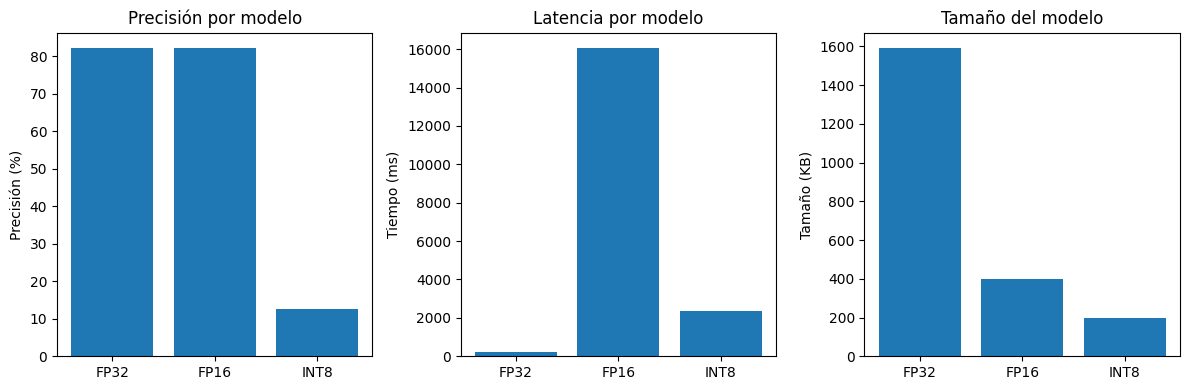

In [65]:
# Cargar pesos pre-entrenados
pesos_previamente_entrenados = NeuralNetwork.load_weights('pesos_256.bin')

# Crear instancia de la red neuronal y asignar los pesos cargados
nn = NeuralNetwork(input_size=784, hidden_size=256, output_size=10)
nn.w1 = pesos_previamente_entrenados['w1']
nn.b1 = pesos_previamente_entrenados['b1']
nn.w2 = pesos_previamente_entrenados['w2']
nn.b2 = pesos_previamente_entrenados['b2']

# Cargar datos de prueba (ejemplo con MNIST)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test.reshape(-1, 784) / 255.0  # Normalizar y aplanar
y_test_labels = y_test  # Guardar las etiquetas originales para la comparación

# Comparar los modelos (FP32, FP16 e INT8)
resultados_comparacion = nn.comparar_modelos(X_test, y_test_labels)

# Opcional: Mostrar gráficamente los resultados
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 3, 1)
plt.bar(resultados_comparacion.keys(),
        [resultados_comparacion[m]['precision'] for m in resultados_comparacion])
plt.title('Precisión por modelo')
plt.ylabel('Precisión (%)')

# Gráfico de latencia
plt.subplot(1, 3, 2)
plt.bar(resultados_comparacion.keys(),
        [resultados_comparacion[m]['latencia']*1000 for m in resultados_comparacion])
plt.title('Latencia por modelo')
plt.ylabel('Tiempo (ms)')

# Gráfico de tamaño
plt.subplot(1, 3, 3)
plt.bar(resultados_comparacion.keys(),
        [resultados_comparacion[m]['tamano'] for m in resultados_comparacion])
plt.title('Tamaño del modelo')
plt.ylabel('Tamaño (KB)')

plt.tight_layout()
plt.show()


### Range tuning and centering
For quantization to be effective, you should smartly choose the range of numbers you will code with the fewer bits available after quantization. To do so, you should evaluate the dynamic ranges of the variables to be quantized and map the values using that as the full range.

Make a histogram plot of the model weights in order to verify their range. Then write a function to quantize the weights stored in the exported binary file to INT8 and store the resulting weights in another file. Finally, run again the INT8 quantized inference with the newly computed weights and compare with the previous versions using the same metrics.

In [66]:
import matplotlib.pyplot as plt
import numpy as np


def plot_histogram(weights):
  pesos_total= np.concatenate([
        weights['w1'].flatten(),
        weights['b1'].flatten(),
        weights['w2'].flatten(),
        weights['b2'].flatten()
    ])
  plt.figure(figsize=(8, 5))
  plt.hist(pesos_total, bins=50, color='#B39DDB', edgecolor='black')
  plt.title('Histograma de pesos del modelo')
  plt.xlabel('Valor del peso')
  plt.ylabel('Apariciones')
  plt.grid(True)
  plt.show()

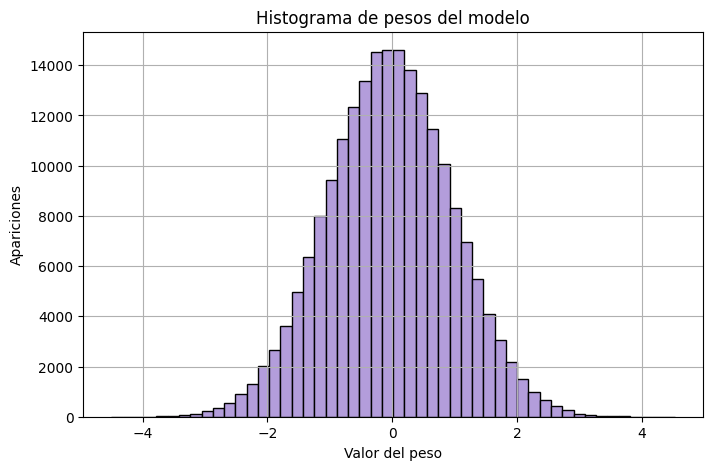

In [67]:
plot_histogram(pesos_previamente_entrenados)

* Cuántización a INT8

In [68]:
def quantize_and_save_all_INT8(weights_dict, output_path="pesos_INT8_completos.bin"):

    pesos_cuantizados = {}

    for key, weights in weights_dict.items():
        # 1. Aplicar esquema de cuantización original
        weights = np.array(weights, dtype=np.float32)
        min_val = -3.7
        max_val =  3.7
        scale = 256.0 / (max_val - min_val)
        zero_point = -int(scale * min_val) - 128
        weights_quant = np.round(scale * weights + zero_point).astype(np.int8)
        pesos_cuantizados[key] = weights_quant

    # 2. Guardar TODOS los pesos en un solo archivo
    with open(output_path, "wb") as f:
        pickle.dump(pesos_cuantizados, f)


In [69]:
def evaluar_int8_con_pesos_cuantizados(x_test, y_test, resultados_previos):
    import time
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. Cargar pesos cuantizados
    with open("pesos_INT8_completos.bin", "rb") as f:
        pesos_int8 = pickle.load(f)

    # 2. Configurar modelo
    nn = NeuralNetwork(784, 256, 10)

    # Asignar pesos cuantizados (convertidos a float32 para operaciones)
    nn.w1 = pesos_int8['w1'].astype(np.float32)
    nn.b1 = pesos_int8['b1'].astype(np.float32)
    nn.w2 = pesos_int8['w2'].astype(np.float32)
    nn.b2 = pesos_int8['b2'].astype(np.float32)

    # 3. Evaluar
    inicio = time.time()
    salida_int8 = nn.INT8(x_test)
    tiempo_int8 = time.time() - inicio
    precision_int8 = np.mean(np.argmax(salida_int8, axis=1) == y_test)

    # 4. Comparación de los INT8
    print("\nCOMPARACIÓN INT8 CON PESOS CUANTIZADOS vs INT8 ANTERIOR:")
    print(f"{'Métrica':<15} {'INT8 (nuevo)':<15} {'INT8 (previo)':<15}")
    print("-" * 45)

    print(f"{'Precisión (%)':<15} {precision_int8 * 100:<15.2f} {resultados_previos['INT8']['precision']:<15.2f}")
    print(f"{'Latencia (s)':<15} {tiempo_int8:<15.4f} {resultados_previos['INT8']['latencia']:<15.4f}")
    print(f"{'Tamaño (KB)':<15} {resultados_previos['INT8']['tamano']:<15.2f} {resultados_previos['INT8']['tamano']:<15.2f}")

    # 5. Gráficos
    modelos = ['INT8 (nuevo)', 'INT8 (previo)']
    metricas = {
        'Precisión (%)': [precision_int8 * 100, resultados_previos['INT8']['precision']],
        'Latencia (s)': [tiempo_int8, resultados_previos['INT8']['latencia']]
    }

    plt.figure(figsize=(10, 4))
    for i, (metrica, valores) in enumerate(metricas.items()):
        plt.subplot(1, 2, i+1)
        bars = plt.bar(modelos, valores, color=['skyblue', 'lightgray'])
        plt.title(metrica)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')
        plt.xticks(rotation=15)

    plt.tight_layout()
    plt.show()

    return {
        'INT8_cuantizado': {
            'precision': precision_int8 * 100,
            'latencia': tiempo_int8,
            'tamano': resultados_previos['INT8']['tamano']
        }
    }


In [70]:
# 1. Cargar pesos originales
pesos_originales = NeuralNetwork.load_weights('pesos_256.bin')

# 2. Cuantizar y guardar TODO (w1, b1, w2, b2) en un archivo
quantize_and_save_all_INT8(pesos_originales)

<ipython-input-63-7597695d1493>:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



COMPARACIÓN INT8 CON PESOS CUANTIZADOS vs INT8 ANTERIOR:
Métrica         INT8 (nuevo)    INT8 (previo)  
---------------------------------------------
Precisión (%)   13.21           12.52          
Latencia (s)    3.6601          2.3815         
Tamaño (KB)     198.76          198.76         


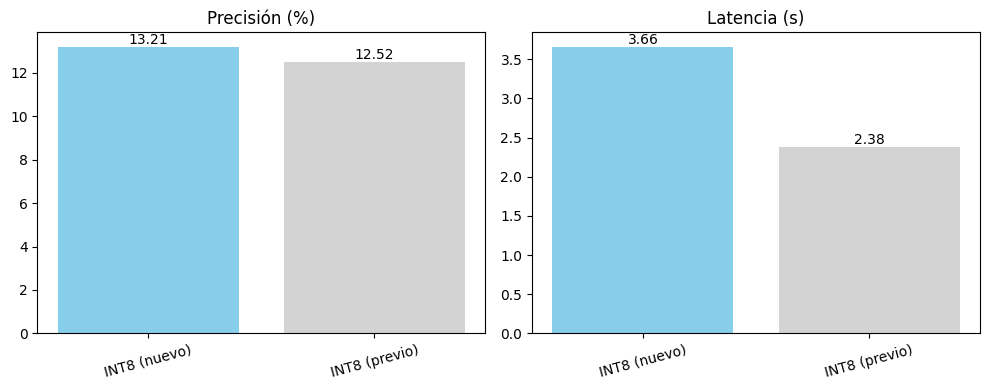

In [71]:
resultados_int8_cuantizado = evaluar_int8_con_pesos_cuantizados(X_test, y_test_labels, resultados_comparacion)

### Pruning
Besides reducing precision for the network weights, we can also decide to eliminate network connections that do not contribute significantly to the model. This can be achieved by simply removing the connections whose weights are closest to zero.

In this part of the lab you are asked to generate three pruned versions of the original model by setting to zero some of the weights:


*   Set to zero the smallest 10% of weights
*   Set to zero the smallest 30% of weights
*   Set to zero the smallest 50% of weights

Report the accuracy for each model against the estimated memory savings.



In [72]:
def prune_model(weights, percentage):
    weights_pruned = weights.copy()
    flattened = np.abs(weights_pruned.flatten())
    threshold = np.percentile(flattened, percentage)
    weights_pruned[np.abs(weights_pruned) <= threshold] = 0
    return weights_pruned



Evaluando modelo podado al 10%

Evaluando modelo podado al 30%

Evaluando modelo podado al 50%

Evaluando modelo podado al 60%

Evaluando modelo podado al 70%

Evaluando modelo podado al 80%

RESULTADOS DE MODELOS PODADOS:
Modelo          Precisión (%)   Memoria usada (KB)     Ahorro memoria (KB)   
---------------------------------------------------------------------------
Poda 10%        82.16           715.53                 79.51                 
Poda 30%        81.23           556.53                 238.51                
Poda 50%        76.94           397.52                 397.52                
Poda 60%        73.26           318.02                 477.02                
Poda 70%        65.05           238.51                 556.53                
Poda 80%        50.22           159.01                 636.03                


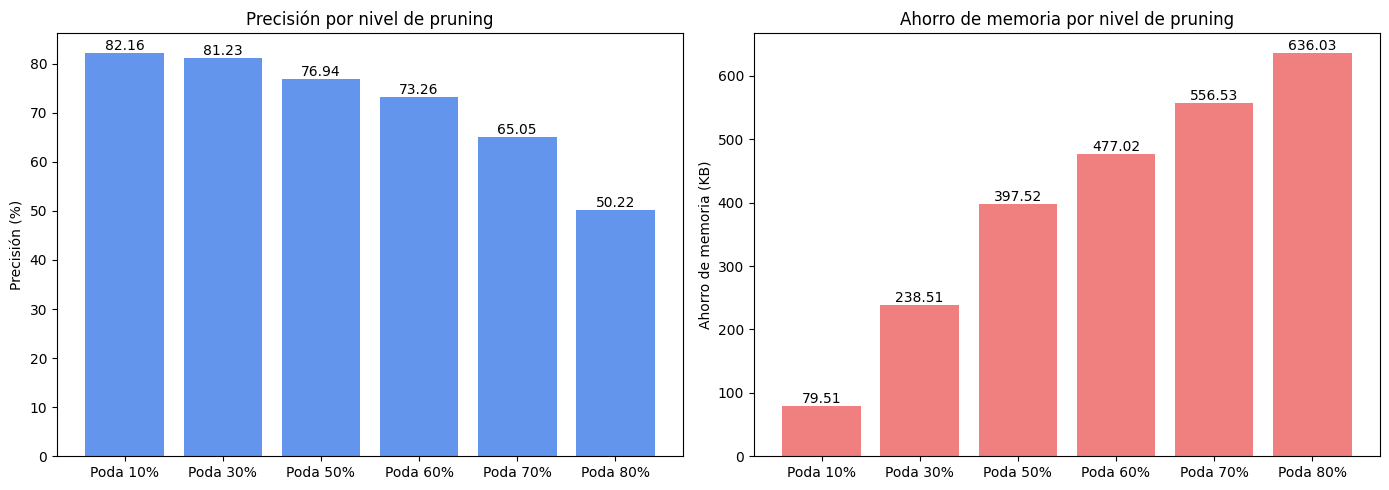

In [73]:
def evaluar_modelos_podados(pesos_originales, x_test, y_test):
    porcentajes_poda = [10, 30, 50,60,70,80]
    resultados = {}

    total_pesos = sum([np.prod(pesos_originales[k].shape) for k in pesos_originales])
    memoria_total_bytes = total_pesos * 4  # float32 = 4 bytes
    memoria_total_kb = memoria_total_bytes / 1024

    for porcentaje in porcentajes_poda:
        print(f"\nEvaluando modelo podado al {porcentaje}%")

        pesos_podados = {
            'w1': prune_model(pesos_originales['w1'], porcentaje),
            'b1': prune_model(pesos_originales['b1'], porcentaje),
            'w2': prune_model(pesos_originales['w2'], porcentaje),
            'b2': prune_model(pesos_originales['b2'], porcentaje)
        }

        ceros_totales = sum([np.sum(pesos_podados[k] == 0) for k in pesos_podados])
        memoria_usada_kb = ((total_pesos - ceros_totales) * 4) / 1024
        ahorro_memoria_kb = memoria_total_kb - memoria_usada_kb

        nn = NeuralNetwork(784, 256, 10)
        nn.w1 = pesos_podados['w1']
        nn.b1 = pesos_podados['b1']
        nn.w2 = pesos_podados['w2']
        nn.b2 = pesos_podados['b2']

        salida = nn.forward(x_test)
        precision = np.mean(np.argmax(salida, axis=1) == y_test) * 100

        resultados[f'Poda {porcentaje}%'] = {
            'precisión (%)': precision,
            'memoria usada (KB)': memoria_usada_kb,
            'ahorro memoria (KB)': ahorro_memoria_kb
        }

    # Mostrar resultados
    print("\nRESULTADOS DE MODELOS PODADOS:")
    print(f"{'Modelo':<15} {'Precisión (%)':<15} {'Memoria usada (KB)':<22} {'Ahorro memoria (KB)':<22}")
    print("-"*75)
    for modelo, res in resultados.items():
        print(f"{modelo:<15} {res['precisión (%)']:<15.2f} {res['memoria usada (KB)']:<22.2f} {res['ahorro memoria (KB)']:<22.2f}")

    # Gráficas
    modelos = list(resultados.keys())
    precisiones = [resultados[m]['precisión (%)'] for m in modelos]
    mem_usada = [resultados[m]['memoria usada (KB)'] for m in modelos]
    mem_ahorro = [resultados[m]['ahorro memoria (KB)'] for m in modelos]

    plt.figure(figsize=(14, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    bars1 = plt.bar(modelos, precisiones, color='cornflowerblue')
    plt.ylabel("Precisión (%)")
    plt.title("Precisión por nivel de pruning")
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

    # Ahorro de memoria
    plt.subplot(1, 2, 2)
    bars2 = plt.bar(modelos, mem_ahorro, color='lightcoral')
    plt.ylabel("Ahorro de memoria (KB)")
    plt.title("Ahorro de memoria por nivel de pruning")
    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



evaluar_modelos_podados(pesos_originales, x_test, y_test)


## Analysis

Discuss the following questions based on the lab experiments and the theory studied:


*   What are the advantages an disadvantages of storing model weights in different formats?
*   How much reduction in model memory requirements can be achieved by each of the versions obtained?
*   What are the posible computational advantages of the obtained models and how do they depend on the hardware?



*   What are the advantages an disadvantages of storing model weights in different formats?
  * Ventajas:
      * La principal ventaja de guardar un modelo en diferentes formatos es el costo computacional que tiene en cada uno, es decir, si es un formato liviano este permite ser implementado en sistemas donde no se cuenta con alta capacidad computacional como lo es un sistema embebido, donde los recursos de memoria y procesamiento son limitados.
      * Otra ventaja es que si no son sistemas donde el fallo sea crítico son una opción barata (computacionalmente) y funcional para dar solución a problemas con machine learning.

  * Desventajas:
      * La principal desventaja es que en la medida en que el modelo este almacenado en un formato menos pesado, el sistema tenderá a perder en rendimiento, como se ve en la figura de accuracy en que se comparan todos los formatos para un mismo modelo.

      * Relacionado con lo anterior, el tener un formato donde no se tenga una alta información tiene principalmente el problema de la pérdida de información en los pesos, haciendo que la red sea "menos inteligente".

* How much reduction in model memory requirements can be achieved by each of the versions obtained?
  * La reducción en memoria del modelo es altamente notoria, por ejemplo, para el modelo de FP32, se tiene un peso de casi 1600KB, para el de FP16, el costo en memoria es de casi 400KB y el de INT8, es de solo casi 200KB. Lo anterior demuestra el hecho de que los modelos se optimizan en costo computacional, pero, a su vez se ve en las mismas gráficas que paga el precio en el rendimiento o inteligencia de esta.
  * También se evidencia que un modelo en el cual se ha hecho pruning, el costo en memoria se reduce en la medida en que la reducción de pesos (pesos en cero) se mayor también el peso del modelo reducirá, como se ve en las gráficas de pruning (poda).

* What are the posible computational advantages of the obtained models and how do they depend on the hardware?
  * Las principales ventajas de los modelos obtenidos son la mediación entre el costo computacional, el tiempo en latencia y el accuracy de los modelos, puesto que el tener modelos con diferentes carácterísiticas en estas métricas da una infinidad opciones en la implementación. Para sistemas críticos, el costo computacional puede ser sacrificado por accuracy, mienrras, que para sistemas embebidos o de poca capacidad computacional se puede optar por modelos no tan robustos pero, livianos a nivel de hardware. La dependencia de estos modelos con el hardware son evidentes en la latencia y el peso de almacenamiento y procesamiento del mismo modelo, puesto que si se tiene un sistema de Hw potente esta latencia tenderá a bajar y el impacto del peso de estos puede ser despreciable y no tenido en cuenta.


### Conlusiones

* Compromiso entre Eficiencia y Rendimiento
Los diferentes formatos de almacenamiento de pesos (FP32, FP16, INT8) y técnicas como pruning permiten reducir significativamente los requisitos de memoria y acelerar la inferencia, pero esto conlleva una pérdida de precisión (accuracy). La elección del formato óptimo depende del contexto: sistemas embebidos priorizan eficiencia, mientras que aplicaciones críticas requieren máxima precisión.

* Reducción de Memoria y Hardware Específico
Se observó una reducción drástica en el tamaño del modelo (de ~1600KB en FP32 a ~200KB en INT8), lo que facilita su implementación en dispositivos con recursos limitados. Sin embargo, el rendimiento computacional como la latencia varía según el hardware; arquitecturas especializadas (GPUs con soporte para FP16/INT8) aprovechan mejor estos formatos optimizados. Adicional a lo anterior, se dene tener en cuenta el tiempo que conlleva a el modelo la cuántización de los datos, lo cual también puede ser uno de los causantes de una alta latencia en el sistema.

* Flexibilidad en Implementación según Necesidades
Las técnicas de optimización (quantization, pruning) brindan versatilidad para adaptar modelos a diferentes entornos. Mientras que sistemas de alto rendimiento pueden usar modelos sin pérdida (FP32), aplicaciones en tiempo real o IoT se benefician de versiones ligeras (INT8), demostrando que no existe una solución única, sino un balance entre velocidad, tamaño y precisión según los requisitos del proyecto.
* Frente a la respuesta en latencia de los modelos se puede ver que el FP32 es el mejor modelo frente a la latencia, seguido del INT8 y el peor el modelo de FP16. Esto demuestra que frente a la latencia puede predominar el HW en que se esta ejecutando el modelo, puesto que muchas veces el HW con que se cuenta esta altamente optimizado para el trabajo en 32 bits.
* La aplicación de poda progresiva a los pesos del modelo evidencia una relación inversa entre la cantidad de pesos eliminados y la precisión del modelo. Con niveles bajos de poda, como el 10% y el 30%, se mantiene una alta precisión (82.16% y 81.23% respectivamente), mientras se logra un ahorro considerable de memoria, lo que sugiere que el modelo contiene redundancia que puede eliminarse sin afectar significativamente su desempeño. Sin embargo, al incrementar la poda a partir del 50%, la precisión comienza a deteriorarse notablemente, llegando a solo 50.22% con una poda del 80%. Por tanto, se concluye que niveles de poda entre 30% y 50% representan un equilibrio eficiente entre reducción de memoria y conservación del rendimiento predictivo del modelo.